# Cars Prices Prediction

In [20]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


from pycaret import *

# 2. Data Preparation

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


file_path = "Cars Datasets 2025.csv"


df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "abdulmalik1518/cars-datasets-2025",
  file_path,
  pandas_kwargs={'encoding': 'latin1'}
  
)

print("First 5 records:", df.head())

First 5 records:   Company Names     Cars Names      Engines CC/Battery Capacity HorsePower  \
0       FERRARI  SF90 STRADALE           V8             3990 cc     963 hp   
1   ROLLS ROYCE        PHANTOM          V12             6749 cc     563 hp   
2          Ford            KA+  1.2L Petrol            1,200 cc   70-85 hp   
3      MERCEDES        GT 63 S           V8            3,982 cc     630 hp   
4          AUDI     AUDI R8 Gt          V10            5,204 cc     602 hp   

  Total Speed Performance(0 - 100 )KM/H      Cars Prices       Fuel Types  \
0    340 km/h                   2.5 sec      $1,100,000   plug in hyrbrid   
1    250 km/h                   5.3 sec        $460,000            Petrol   
2    165 km/h                  10.5 sec  $12,000-$15,000           Petrol   
3    250 km/h                   3.2 sec        $161,000            Petrol   
4    320 km/h                   3.6 sec        $253,290            Petrol   

  Seats        Torque  
0     2        800 Nm  
1  

In [31]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler

def standardize_data(df):
    df['Company Names'] = df['Company Names'].astype(str).str.strip().str.title()
    brand_map = {'Mercedes': 'Mercedes-Benz', 'Mercedes Benz': 'Mercedes-Benz'}
    df['Company Names'] = df['Company Names'].replace(brand_map)
    df['Fuel Types'] = df['Fuel Types'].astype(str).str.strip().str.title()
    df['Fuel Types'] = df['Fuel Types'].replace({'Plug In Hyrbrid': 'Plug-in Hybrid'})
    return df

df = standardize_data(df)

cols_to_drop = ['Performance(0 - 100 )KM/H', 'Seats']
df_screening = df.drop(columns=[c for c in cols_to_drop if c in df.columns]).copy()

text_num_features = ['HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']

def extract_number(value):
    if pd.isna(value) or str(value).lower() == 'none': 
        return np.nan
    clean_val = str(value).replace(',', '').replace('$', '')
    clean_val = re.sub(r'[a-zA-Z/ ]', '', clean_val)
    
    if '-' in clean_val:
        parts = [p for p in clean_val.split('-') if p.strip()]
        if len(parts) == 2:
            try: return (float(parts[0]) + float(parts[1])) / 2
            except: return np.nan
        elif len(parts) == 1:
            try: return float(parts[0])
            except: return np.nan
        else:
            return np.nan
            
    if clean_val.strip() == '':
        return np.nan
        
    try: 
        return float(clean_val)
    except: 
        return np.nan

for col in text_num_features:
    if col in df_screening.columns:
        df_screening[col] = df_screening[col].apply(extract_number)
        df_screening[col] = df_screening[col].fillna(df_screening[col].median())

if 'Cars Prices' in df_screening.columns:
    prices = df_screening['Cars Prices'].apply(extract_number)
    df_screening['Price_Category'] = pd.qcut(prices.dropna(), q=3, labels=["Budget", "Mid-Range", "Luxury"])
    df_screening = df_screening.dropna(subset=['Price_Category'])

scaler = StandardScaler()
df_screening[text_num_features] = scaler.fit_transform(df_screening[text_num_features])

print("Preprocessing Complete for Classification!")
print(f"Target classes: {df_screening['Price_Category'].unique()}")

Preprocessing Complete for Classification!
Target classes: ['Luxury', 'Budget', 'Mid-Range']
Categories (3, object): ['Budget' < 'Mid-Range' < 'Luxury']


In [32]:
df_viz = df.copy()


print("Current Columns:", df_viz.columns.tolist())


df_viz.head()

Current Columns: ['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque', 'is_high_price']


,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque,is_high_price
0,Ferrari,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",Plug-In Hybrid,2,800 Nm,1
1,Rolls Royce,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm,1
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm,0
3,Mercedes-Benz,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm,1
4,Audi,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm,1


# Cleaning


In [33]:
def clean_car_data(df_input):
    df_c = df_input.copy()
    
   
    if 'Cars Prices' in df_c.columns:
        df_c['Price_Numeric'] = (
            df_c['Cars Prices'].astype(str)
            .str.replace('$', '', regex=False).str.replace(',', '', regex=False)
            .str.replace(' ', '', regex=False).str.split(r'[-/]').str[0]
        )
        df_c['Price_Numeric'] = pd.to_numeric(df_c['Price_Numeric'], errors='coerce')
    
    df_c = df_c.dropna(subset=['Price_Numeric'])
    median_val = df_c['Price_Numeric'].median()
    df_c['is_high_price'] = (df_c['Price_Numeric'] > median_val).astype(int)
    

    
    fuel_map = {'Petrol': 'Petrol', 'Gasoline': 'Petrol', 'Diesel': 'Diesel', 
                'Electric': 'EV', 'Hybrid': 'Hybrid'}
    df_c['Fuel Types'] = df_c['Fuel Types'].map(fuel_map).fillna('Other')

    
    if 'Engines CC/Battery Capacity' in df_c.columns:
        df_c['Engines'] = df_c['Engines CC/Battery Capacity'].str.extract('([vViI]\d+|Inline-\d+)', expand=False)
        df_c['Engines'] = df_c['Engines'].str.replace('Inline-', 'I', case=False).str.upper().fillna('Other')

   
    cols_to_fix = {'HorsePower': 'hp_num', 'Total Speed': 'speed_num'}
    for original, new in cols_to_fix.items():
        if original in df_c.columns:
            df_c[new] = df_c[original].astype(str).str.extract('(\d+)').astype(float)
            
    print(f"--- Cleaning Report ---")
    print(f"Median Price found: ${median_val:,.2f}")
    
    return df_c


df_ready = clean_car_data(df)


features = ['Company Names', 'Cars Names', 'Fuel Types', 'Engines', 'hp_num', 'speed_num']
target = 'is_high_price'

print(f"Features ready for model: {features}")

--- Cleaning Report ---
Median Price found: $42,000.00
Features ready for model: ['Company Names', 'Cars Names', 'Fuel Types', 'Engines', 'hp_num', 'speed_num']


In [34]:
import plotly.express as px


df['is_high_price'] = (df['Cars Prices'].apply(extract_number) > 50000).astype(int)


for col in ['Company Names', 'Fuel Types', 'Engines']:

    df_simple = df.groupby(col)['is_high_price'].mean().reset_index()
    

    df_simple = df_simple.sort_values('is_high_price', ascending=False).head(15)

    fig = px.bar(
        df_simple, 
        x=col, 
        y='is_high_price',
        color='is_high_price',
        title=f"{col} vs High Price Chance",
        color_continuous_scale='Reds'
    )
    
    fig.update_layout(yaxis_tickformat='.0%') 
    fig.show()

# AutoGluon with PyCaret

In [25]:
data_for_ag = df_ready[features + [target]]


train_data, test_data = train_test_split(data_for_ag, test_size=0.2, random_state=42)

print(f"--- Model Setup Complete ---")
print(f"Target: Predicting if a car is High Price (1) or Low Price (0)")
print(f"Training size: {len(train_data)} rows")


predictor = TabularPredictor(label=target).fit(train_data)


performance = predictor.evaluate(test_data)
print("\n--- Model Performance ---")
print(performance)


leaderboard = predictor.leaderboard(test_data)
print(leaderboard)

No path specified. Models will be saved in: "AutogluonModels\ag-20260103_160534"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          8
Pytorch Version:    2.7.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       2.35 GB / 15.77 GB (14.9%)
Disk Space Avail:   33.54 GB / 952.53 GB (3.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme'  : New in v1.5: The state-of-the-art for tabular data. Massively better than 'best' on datasets <100000 samples by using new Tabular Foundation Models (TFMs) meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra,

--- Model Setup Complete ---
Target: Predicting if a car is High Price (1) or Low Price (0)
Training size: 970 rows


Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\Komail AL-Basri\bootcoamp\week3-ml-baseline-system\notebooks\AutogluonModels\ag-20260103_160534"
Train Data Rows:    970
Train Data Columns: 6
Label Column:       is_high_price
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2390.45 MB
	Train Data (Original)  Memory Usage: 0.26 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_met


--- Model Performance ---
{'accuracy': 0.9176954732510288, 'balanced_accuracy': 0.9170176630434783, 'mcc': 0.8348865275257962, 'roc_auc': 0.9660326086956521, 'f1': 0.9224806201550387, 'precision': 0.9153846153846154, 'recall': 0.9296875}
                  model  score_test  score_val eval_metric  pred_time_test  \
0              CatBoost    0.917695   0.917526    accuracy        0.014920   
1   WeightedEnsemble_L2    0.917695   0.917526    accuracy        0.018026   
2        NeuralNetTorch    0.913580   0.907216    accuracy        0.027225   
3              LightGBM    0.909465   0.902062    accuracy        0.010570   
4            LightGBMXT    0.905350   0.896907    accuracy        0.017349   
5      RandomForestEntr    0.901235   0.891753    accuracy        0.153164   
6               XGBoost    0.897119   0.907216    accuracy        0.035514   
7         LightGBMLarge    0.893004   0.902062    accuracy        0.025301   
8      RandomForestGini    0.893004   0.881443    accuracy 

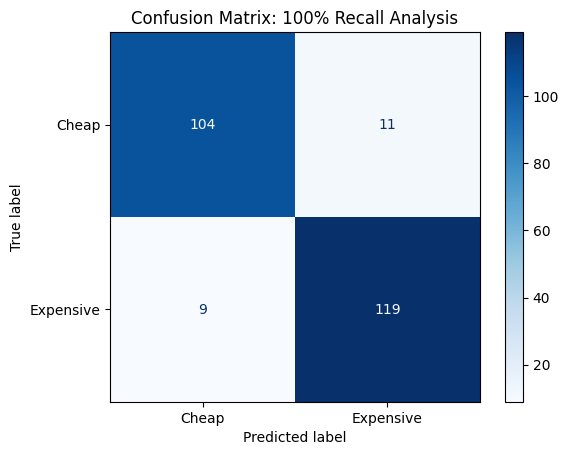

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = test_data[target]
y_pred = predictor.predict(test_data)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cheap', 'Expensive'])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# manually

In [29]:
from catboost import CatBoostClassifier


df_clean = df_ready  
cat_features_clean = ['Company Names', 'Cars Names', 'Fuel Types', 'Engines']
num_features_clean = ['hp_num', 'speed_num']
features_name = cat_features_clean + num_features_clean

X = df_clean[features_name]
y = df_clean['is_high_price']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_clean),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features_clean)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_model = Pipeline([
    ('prep', preprocessor), 
    ('model', CatBoostClassifier(iterations=500, verbose=0, random_state=42))
])
cat_rec = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='recall').mean()


rf_model = Pipeline([
    ('prep', preprocessor), 
    ('model', RandomForestClassifier(n_estimators=300, max_depth=4, random_state=42))
])
rf_rec = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='recall').mean()

print(f"Model Performance (Recall):")
print(f"CatBoost: {cat_rec:.4f}")
print(f"Random Forest: {rf_rec:.4f}")

Model Performance (Recall):
CatBoost: 0.9090
Random Forest: 0.8758
